Data treatment 
Data cleaning, feature engineering, data evaluation

In [1]:
import os
from enum import auto
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm

For the 1-10 hours database

In [2]:
## Open the file
Data_raw = pd.read_csv(r"Y:\36 TP\MAPbBr3\Paper ML crystal\DB_model1.csv", 
                                delimiter = ",")

Cleaning/Manipulation/Feature engineering

In [3]:
# Instead of separated sizes, creating the seed area
Data_raw ['Seed crystal mm2'] = (Data_raw['Seed Size A (mm)']*
                                      Data_raw['Seed Size B (mm)'])

In [4]:
#Removing non-desired features from the raw data - categorical, constants, values obtained in the end and imaging related features
Data_raw = Data_raw.drop(['Hotplate', 'Last Syringe Mass (g)',
                            'Last Solution Mass (g)', 'Last Total Mass (g)',
                            'All Deposited Crystals (g)', 'Total Infusion (g)', 'Total Evaporation (g)', 
                            'Estimated Last Concentration (wt.%)', 'Hotplate Temperature (oC)',
                            'Syringe Diameter (mm)', 'Imaging Width (pixel)',
                            'Imaging Height (pixel)', 'Shot Interval (sec)', 'Mask Radius (pixel)',
                            'Scale (pixel/mm2)', 'B Bottom Threshold', 'G Bottom Threshold',
                            'R Bottom Threshold', 'B Top Threshold', 'G Top Threshold',
                            'R Top Threshold', 'L Smoothing Parameters 1',
                            'L Smoothing Parameters 2', 'G Smoothing Parameters 1',
                            'G Smoothing Parameters 2', 'Smoothed Growth Rate (mm/h)', 'Smoothed Length (mm)',
                            'source', 'Unnamed: 0', 'source.1'], axis=1)

In [ ]:
# Correlation plot
plt.figure(figsize=(10,8))
heatmap = sns.heatmap(Data_raw.corr(), vmin=-1, vmax=1, annot=False, 
                    cmap= cm.vik, #'viridis', #cmocean.cm.matter,
                    square=True)
heatmap.set_xticklabels(heatmap.get_xticklabels(),
                   rotation=45,
                   horizontalalignment='right')
# Gerar o nome do arquivo
file_name = 'Y:\36 TP\MAPbBr3\Paper ML crystal/corr_plot_1_10_1st.png'

plt.tight_layout()
plt.savefig(file_name, dpi=500)
plt.show()


In [5]:
# Removing non-desired features from the raw data - correlated and redundant features
Data_raw = Data_raw.drop(['Crystal Size A (mm)', 'Crystal Size B (mm)', 'Crystal Size C (mm)', 'Number of Crystals',
                            'integral e', 'Length (mm)', 'Kp', 'Ki', 'Kd', 'de/dt', 'e(t)',
                            'Initial Infusion Rate (mL/h)', 'Total Infusion (mL)',
                            'Initial Syringe Mass (g)', 'Initial Total Mass (g)',
                            'Est-Mass (g)', 'Initial Concentration (wt.%)', 'Estimated Evaporation Rate (g/h)',
                            'Seed crystal mm2', 'Seed Size A (mm)', 'Seed Size B (mm)', 'Seed Size C (mm)'], axis=1)

In [6]:
Data_final = Data_raw

In [7]:
# Rename columns
Data_final = Data_final.rename(columns=
                                 {'Initial Solution Mass (g)':'Initial_Solution_Mass',
                                  'Room Temperature (oC)':'Room_Temperature', 
                                  'Humidity (RH%)': 'Humidity',
                                  'Evaporation Rate (g/h)': 'Evaporation_Rate',
                                  'Ideal Growth Rate (mm/h)': 'Ideal_Growth_Rate', 
                                  'Time (h)': 'Time', 
                                  'Infusion Rate (mL/h)': 'Infusion_Rate',
                                  'Area (mm2)': 'Area', 
                                  'Growth Rate (mm/h)': 'Growth_Rate', 
                                  'Estimated Concentration (wt.%)': 'Estimated_Concentration'})

In [8]:
# New order of columns
new_order = ['Initial_Solution_Mass', 'Room_Temperature', 'Humidity',
       'Evaporation_Rate', 'Ideal_Growth_Rate', 'Infusion_Rate', 'Time',
       'Area', 'Growth_Rate', 'Estimated_Concentration']

Data_final = Data_final.reindex(columns=new_order)

In [9]:
# Removing NA values and negative values from evaporation rate and estimated concentration
Data_final = Data_final.dropna()
Data_final = Data_final[Data_final['Evaporation_Rate'] >= 0]
Data_final = Data_final[Data_final['Estimated_Concentration'] >= 0]

In [ ]:
# Correlation plot
plt.figure(figsize=(10,8))
heatmap = sns.heatmap(Data_raw.corr(), vmin=-1, vmax=1, annot=False, 
                    cmap= cm.vik,
                    square=True)
heatmap.set_xticklabels(heatmap.get_xticklabels(),
                   rotation=45,
                   horizontalalignment='right')

# Gerar o nome do arquivo
file_name = 'Y:\36 TP\MAPbBr3\Paper ML crystal/corr_plot_1_10_2nd.png'

plt.tight_layout()
plt.savefig(file_name, dpi=500)
plt.show()

Models development/training

In [10]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn import metrics
from pprint import pprint
from hyperopt import hp, fmin, tpe, space_eval, Trials
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold

In [11]:
## x and y subsets
x = Data_final.drop(['Evaporation_Rate'], axis=1)
y = Data_final[['Evaporation_Rate']]

np.random.seed(100)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=25) # 75% training and 25% test

Decision trees

In [ ]:
####### to optimize hyperparameters, do the lines below
# Define the search space
space = {
    'max_depth': hp.choice('max_depth', range(1, 800)),
    'max_features': hp.choice('max_features', [1.0, 'sqrt']),
    'max_leaf_nodes': hp.choice('max_leaf_nodes', range(2, 500)),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(2, 10)),
    'min_samples_split': hp.choice('min_samples_split', range(2, 10)),
    'min_weight_fraction_leaf': hp.choice('min_weight_fraction_leaf', [0.1])
}

cv = KFold(n_splits=5, random_state=25, shuffle=True)
# Define the objective function
def objective(params):
    dt = DecisionTreeRegressor(**params)
    scores = cross_val_score(dt, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-scores.mean()) 
    return rmse

# Run the hyperparameter optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=200, trials=trials)

# Get the best hyperparameters
best_params = space_eval(space, best)

# Create a Decision Tree regressor with the best hyperparameters
dt = DecisionTreeRegressor(**best_params)
scores = cross_val_score(dt, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')

dt.fit(X_train, y_train)

# Prediction on test set
y_pred = dt.predict(X_test)
y_pred_train = dt.predict(X_train)

print(best_params)

In [30]:
## Optimized model for decision trees
# Create the parameter grid based on the results of random search - using hyperopt   --- decision trees
best_params = {
              'max_depth': 423, 
              'max_features':1.0, 
              'max_leaf_nodes': 119,
              'min_weight_fraction_leaf': 0.1, 
              'min_samples_leaf': 7,
              'min_samples_split': 8 
}
# Create a Decision Tree regressor with the best hyperparameters
dt = DecisionTreeRegressor(**best_params)
dt.fit(X_train, y_train)

# Prediction on test set
y_pred = dt.predict(X_test)
y_pred_train = dt.predict(X_train)

In [ ]:
# Training metrics
MAE_train_dt = pd.DataFrame(mean_absolute_error(y_train, y_pred_train, multioutput='raw_values'))
RMSE_train_dt = pd.DataFrame(np.sqrt(mean_squared_error(y_train, y_pred_train, multioutput='raw_values')))
R2_train_dt = pd.DataFrame(r2_score(y_train, y_pred_train, multioutput='raw_values'))
train_metrics_dt = pd.concat([MAE_train_dt, RMSE_train_dt, R2_train_dt], axis='columns')
train_metrics_dt.columns = ['MAE_train', 'RMSE_train', 'R2_train']
print(train_metrics_dt)

# Test metrics
MAE_test_dt = pd.DataFrame(mean_absolute_error(y_test, y_pred, multioutput='raw_values'))
RMSE_test_dt = pd.DataFrame(np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values')))
R2_test_dt = pd.DataFrame(r2_score(y_test, y_pred, multioutput='raw_values'))
test_metrics_dt = pd.concat([MAE_test_dt, RMSE_test_dt, R2_test_dt], axis='columns')
test_metrics_dt.columns = ['MAE_test', 'RMSE_test', 'R2_test']
print(test_metrics_dt)

Random forest

In [ ]:
####### to optimize hyperparameters, do the lines below
# Define the search space
space = {
    'bootstrap': hp.choice('bootstrap', [True, False]),
    'max_depth': hp.choice('max_depth', range(1, 100)),
    'max_features': hp.choice('max_features', [1.0, 'sqrt']),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(2, 10)),
    'min_samples_split': hp.choice('min_samples_split', range(2, 10)),
    'n_estimators': hp.choice('n_estimators', range(100, 500))
}

cv = KFold(n_splits=5, random_state=25, shuffle=True)
# Define the objective function
def objective(params):
    rf = RandomForestRegressor(**params)
    scores = cross_val_score(rf, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-scores.mean()) 
    return rmse

# Run the hyperparameter optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=2, trials=trials)

# Get the best hyperparameters
best_params = space_eval(space, best)

# Create a Random Forest regressor with the best hyperparameters
rf = RandomForestRegressor(**best_params)
scores = cross_val_score(rf, X_train, y_train, scoring='neg_mean_squared_error')

rf.fit(X_train, y_train)

# Prediction on test set
y_pred = rf.predict(X_test)


print(best_params)

In [12]:
# random forest optimized
 #### after defined the search space
best_params = {
    'bootstrap': False,
    'max_depth': 550,
    'max_features': 'sqrt',
    'min_samples_leaf': 2,
    'min_samples_split': 4,
    'n_estimators': 250,
}

# Create a Random Forest regressor with the best hyperparameters - hyperopt
rf = RandomForestRegressor(**best_params)
rf.fit(X_train, np.ravel(y_train))  

# Prediction on test set
y_pred = rf.predict(X_test)
y_pred_train = rf.predict(X_train)

In [ ]:
# Training metrics
MAE_train_rf = pd.DataFrame(mean_absolute_error(y_train, y_pred_train, multioutput='raw_values'))
RMSE_train_rf = pd.DataFrame(np.sqrt(mean_squared_error(y_train, y_pred_train, multioutput='raw_values')))
R2_train_rf = pd.DataFrame(r2_score(y_train, y_pred_train, multioutput='raw_values'))
train_metrics_rf = pd.concat([MAE_train_rf, RMSE_train_rf, R2_train_rf], axis='columns')
train_metrics_rf.columns = ['MAE_train', 'RMSE_train', 'R2_train']
print(train_metrics_rf)

# Test metrics
MAE_test_rf = pd.DataFrame(mean_absolute_error(y_test, y_pred, multioutput='raw_values'))
RMSE_test_rf = pd.DataFrame(np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values')))
R2_test_rf = pd.DataFrame(r2_score(y_test, y_pred, multioutput='raw_values'))
test_metrics_rf = pd.concat([MAE_test_rf, RMSE_test_rf, R2_test_rf], axis='columns')
test_metrics_rf.columns = ['MAE_test', 'RMSE_test', 'R2_test']
print(test_metrics_rf)

XGBoost

In [ ]:
####### to optimize hyperparameters, do the lines below
# Define the search space
space = {
    'max_depth': hp.choice('max_depth', range(20, 50)),
    'learning_rate': hp.uniform('learning_rate', 0.03, 0.08),
    'n_estimators': hp.choice('n_estimators', range(400,1000)),
    'gamma': hp.uniform('gamma', 0.3, 0.7),
    'min_child_weight': hp.choice('min_child_weight', range(5, 15)),
    'subsample': hp.uniform('subsample', 0.1, 0.8),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.4, 0.8)
}

cv = KFold(n_splits=5, random_state=25, shuffle=True)
# Define the objective function
def objective(params):
    xgb_reg = xgb.XGBRegressor(**params, random_state=42)
    scores = cross_val_score(xgb_reg, X_train, y_train, cv=cv, scoring='r2')
    rmse = np.sqrt(-scores.mean())
    return rmse 


# Run the hyperparameter optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=30, trials=trials)

# Get the best hyperparameters
best_params = space_eval(space, best)

# Create a Decision Tree regressor with the best hyperparameters
xgb = xgb.XGBRegressor(**best_params)
scores = cross_val_score(xgb, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')

xgb.fit(X_train, y_train)

# Prediction on test set
y_pred = xgb.predict(X_test)
y_pred_train = xgb.predict(X_train)

print(best_params)

In [12]:
# xgboost optimized with hyperopt

best_params = {
    'max_depth': 10,
    'learning_rate': 0.04,
    'n_estimators': 1000,
    'gamma': 0.1,
    'min_child_weight': 10,
    'subsample': 0.6,
    'colsample_bytree': 0.6,
    'lambda': 1,
    'alpha': 0
}

# Create a Random Forest regressor with the best hyperparameters - hyperopt
xgb = xgb.XGBRegressor(**best_params)
xgb.fit(X_train, y_train)

# Prediction on test set
y_pred = xgb.predict(X_test)
y_pred_train = xgb.predict(X_train)

In [ ]:
# Training metrics
MAE_train_xgb = pd.DataFrame(mean_absolute_error(y_train, y_pred_train, multioutput='raw_values'))
RMSE_train_xgb = pd.DataFrame(np.sqrt(mean_squared_error(y_train, y_pred_train, multioutput='raw_values')))
R2_train_xgb = pd.DataFrame(r2_score(y_train, y_pred_train, multioutput='raw_values'))
train_metrics_xgb = pd.concat([MAE_train_xgb, RMSE_train_xgb, R2_train_xgb], axis='columns')
train_metrics_xgb.columns = ['MAE_train', 'RMSE_train', 'R2_train']
print(train_metrics_xgb)

# Test metrics
MAE_test_xgb = pd.DataFrame(mean_absolute_error(y_test, y_pred, multioutput='raw_values'))
RMSE_test_xgb = pd.DataFrame(np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values')))
R2_test_xgb = pd.DataFrame(r2_score(y_test, y_pred, multioutput='raw_values'))
test_metrics_xgb = pd.concat([MAE_test_xgb, RMSE_test_xgb, R2_test_xgb], axis='columns')
test_metrics_xgb.columns = ['MAE_test', 'RMSE_test', 'R2_test']
print(test_metrics_xgb)

Features importance - SHAP and PFI

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from pprint import pprint
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance
import shap

For decision trees

In [ ]:
# Features importance by permutation - test set
result = permutation_importance(dt, X_test, y_test, n_repeats=10, random_state=42)
importances = result.importances_mean

# Order importances and features names
indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices]
sorted_feature_names = [X_test.columns[i] for i in indices]

# Colormap into colors list
n_colors = len(sorted_importances) 
colors = [cm.vik(i / (n_colors - 1)) for i in range(n_colors)]

# Plot
plt.figure(figsize=(10, 6))
plt.title("Permutation Feature Importance")
sns.barplot(x=sorted_importances, y=sorted_feature_names, palette=colors)
plt.xlabel("Importance")
plt.ylabel("Feature")

# Name file
file_name = r'Y:\36 TP\MAPbBr3\Paper ML crystal\feat_imp_DT.png'

plt.tight_layout()
plt.savefig(file_name, dpi=500)
plt.show()

In [ ]:
# SHAP plot

# Random 1000 samples on test set
N = 1000
X_sample = X_test.sample(n=N, random_state=42)

explainer = shap.TreeExplainer(dt, data=X_test)

shap_values = explainer.shap_values(X_sample, check_additivity=False)

feature_names = X_test.columns.astype(str)

# Create shap plot
shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=False, cmap=cm.vik)

shap.initjs()

# Name file
file_name = 'Y:\36 TP\MAPbBr3\Paper ML crystal/Shap_DT_1_10.png'

plt.tight_layout()
plt.savefig(file_name, dpi=500)
plt.show()

For Random forest

In [ ]:
# Features importance by permutation
result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)
importances = result.importances_mean

indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices]
sorted_feature_names = [X_test.columns[i] for i in indices]

n_colors = len(sorted_importances) 
colors = [cm.vik(i / (n_colors - 1)) for i in range(n_colors)]

# Plot
plt.figure(figsize=(10, 6))
plt.title("Permutation Feature Importance")
sns.barplot(x=sorted_importances, y=sorted_feature_names, palette=colors)
plt.xlabel("Importance")
plt.ylabel("Feature")

# Name file
file_name = r'Y:\36 TP\MAPbBr3\Paper ML crystal\feat_imp_RF.png'

plt.tight_layout()
plt.savefig(file_name, dpi=500)
plt.show()

100%|===================| 998/1000 [03:41<00:00]        

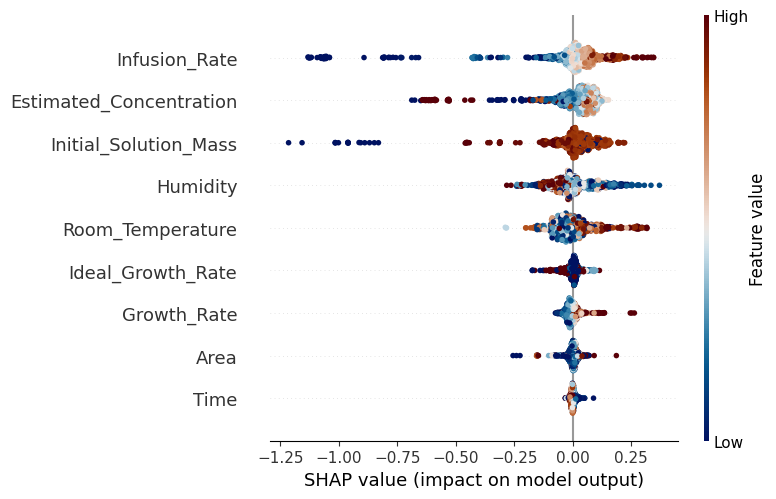

In [14]:
# SHAP plot

# random 1000 samples from test set
N = 1000
X_sample = X_test.sample(n=N, random_state=42)

explainer = shap.TreeExplainer(rf, data=X_test)

shap_values = explainer.shap_values(X_sample, check_additivity=False)

feature_names = X_test.columns.astype(str)

shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=False, cmap=cm.vik)

shap.initjs()

# Name file
file_name = 'Y:\36 TP\MAPbBr3\Paper ML crystal/Shap_RF_1_10.png'

plt.tight_layout()
plt.savefig(file_name, dpi=500)
plt.show()

In [ ]:
# Most important feature --- based on shap values
important_feature_index = np.abs(shap_values.values).mean(axis=0).argsort()[-1]

shap.plots.scatter(shap_values[:, important_feature_index])
plt.show()

In [ ]:
# Dependence Plot -- desired feature to analyze
feature_to_plot = 'Initial_Solution_Mass'  

shap.dependence_plot(feature_to_plot, shap_values, X_sample, feature_names=feature_names)
#shap.plots.scatter(shap_values[:, important_feature_index])

dependence_file_name = r'Y:\36 TP\MAPbBr3\Paper ML crystal\Shap_Dependence_Plot.png'
plt.savefig(dependence_file_name, dpi=500)
plt.show()

For XGBoost

In [ ]:
# Features importance by permutation
result = permutation_importance(xgb, X_test, y_test, n_repeats=10, random_state=42)
importances = result.importances_mean

indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices]
sorted_feature_names = [X_test.columns[i] for i in indices]

n_colors = len(sorted_importances)
colors = [cm.vik(i / (n_colors - 1)) for i in range(n_colors)]

# Plotar
plt.figure(figsize=(10, 6))
plt.title("Permutation Feature Importance")
sns.barplot(x=sorted_importances, y=sorted_feature_names, palette=colors)
plt.xlabel("Importance")
plt.ylabel("Feature")

'''# Name file
file_name = r'Y:\36 TP\MAPbBr3\Paper ML crystal\feat_imp_XGB.png'

plt.tight_layout()
plt.savefig(file_name, dpi=500)'''
plt.show()

In [ ]:
# SHAP plot

N = 1000
X_sample = X_test.sample(n=N, random_state=42)

explainer = shap.TreeExplainer(xgb, data=X_test)

shap_values = explainer.shap_values(X_sample, check_additivity=False)

feature_names = X_test.columns.astype(str)

shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=False, cmap=cm.vik)

shap.initjs()

'''# Name file
file_name = r'Y:\36 TP\MAPbBr3\Paper ML crystal\Shap_XGB_1_10.png'

plt.tight_layout()
plt.savefig(file_name, dpi=500)'''
plt.show()

In [ ]:
shap_values = explainer(X_sample)

In [ ]:
# Most important feature - based on shap values
important_feature_index = np.abs(shap_values.values).mean(axis=0).argsort()[-1]

shap.plots.scatter(shap_values[:, important_feature_index])
plt.show()

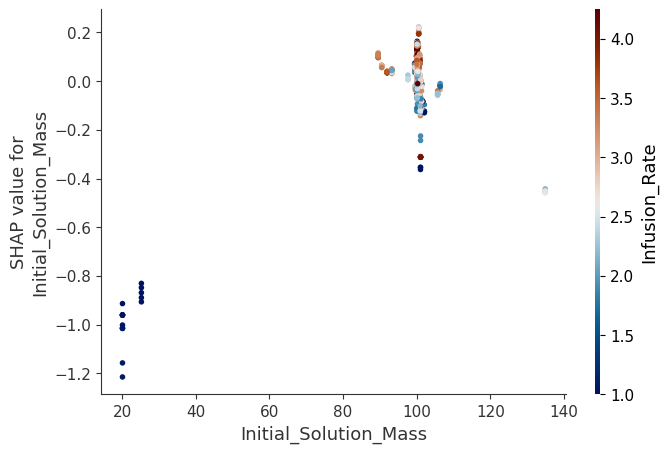

<Figure size 640x480 with 0 Axes>

In [15]:
# Dependence plot - specific feature
feature_to_plot = 'Initial_Solution_Mass'
shap.dependence_plot(feature_to_plot, shap_values, X_sample, feature_names=feature_names, cmap=cm.vik)
#shap.plots.scatter(shap_values[:, important_feature_index])
shap.initjs()

shap.initjs()

# Name file
file_name = 'Y:\36 TP\MAPbBr3\Paper ML crystal/Shap_Dependence_Plot_RF.png'

plt.tight_layout()
plt.savefig(file_name, dpi=500)
plt.show()

Parity plots - Decision trees, Random forest, and XGBoost

In [ ]:
# Parity - DT
# Colors for plot
colors = cm.vik
train_color_index = 0.1
test_color_index = 0.87
train_color = colors(train_color_index)
test_color = colors(test_color_index)

fig, ax = plt.subplots(figsize=(8, 6))

# Scatter plot - train
ax.scatter(y_train, y_pred_train, color=train_color, s=30, label='Train set')

# Scatter plot - test
ax.scatter(y_test, y_pred, color=test_color, s=30, label='Test set')

# Diagonal line
ax.plot([min(min(y_train.values), min(y_test.values)), max(max(y_train.values), max(y_test.values))],
        [min(min(y_train.values), min(y_test.values)), max(max(y_train.values), max(y_test.values))],
        color='black', linestyle='--')

# Lables
ax.set_ylabel('Predicted values', fontsize=22)
ax.set_xlabel('True Values', fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=18, frameon = False, loc='upper left')

# Name file
file_name = 'Y:\36 TP\MAPbBr3\Paper ML crystal/pred_evap_parity_DT_1_10.png'

plt.tight_layout()
plt.savefig(file_name, dpi=500)
plt.show()

In [ ]:
# Parity - RF

colors = cm.vik
train_color_index = 0.1
test_color_index = 0.87
train_color = colors(train_color_index)
test_color = colors(test_color_index)

fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(y_train, y_pred_train, color=train_color, s=30, label='Train set')

ax.scatter(y_test, y_pred, color=test_color, s=30, label='Test set')

ax.plot([min(min(y_train.values), min(y_test.values)), max(max(y_train.values), max(y_test.values))],
        [min(min(y_train.values), min(y_test.values)), max(max(y_train.values), max(y_test.values))],
        color='black', linestyle='--')
ax.set_ylabel('Predicted values', fontsize=22)
ax.set_xlabel('True Values', fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=16)

ax.legend(fontsize=18, frameon = False, loc='upper left')

file_name = r'Y:\36 TP\MAPbBr3\Paper ML crystal\pred_evap_parity_RF_1_10.png'

plt.tight_layout()
plt.savefig(file_name, dpi=500)
plt.show()

In [ ]:
# Parity - XGBoost
colors = cm.vik
train_color_index = 0.1
test_color_index = 0.87
train_color = colors(train_color_index)
test_color = colors(test_color_index)

fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(y_train, y_pred_train, color=train_color, s=30, label='Train set')

ax.scatter(y_test, y_pred, color=test_color, s=30, label='Test set')

ax.plot([min(min(y_train.values), min(y_test.values)), max(max(y_train.values), max(y_test.values))],
        [min(min(y_train.values), min(y_test.values)), max(max(y_train.values), max(y_test.values))],
        color='black', linestyle='--')

ax.set_ylabel('Predicted values', fontsize=22)
ax.set_xlabel('True Values', fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=16)

ax.legend(fontsize=18, frameon = False, loc='upper left')

file_name = r'Y:\36 TP\MAPbBr3\Paper ML crystal\pred_evap_parity_XGBoost_1_10.png'

plt.tight_layout()
plt.savefig(file_name, dpi=500)
plt.show()